In [2]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

### Params

In [3]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)

# = = = = = = = = = = = = = = = = = = = =
# OR use custom date for testing !!!
custom_date = '2024-01-03'
t_now = pd.Timestamp(custom_date).replace(hour=0, minute=0, second=0, microsecond=0)
# = = = = = = = = = = = = = = = = = = = =

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)).tz_localize('CET'))
print(subm_timestamps)

wed = 2024-01-03 00:00:00
thu = 2024-01-04 00:00:00
[Timestamp('2024-01-05 12:00:00+0100', tz='CET'), Timestamp('2024-01-05 16:00:00+0100', tz='CET'), Timestamp('2024-01-05 20:00:00+0100', tz='CET'), Timestamp('2024-01-06 12:00:00+0100', tz='CET'), Timestamp('2024-01-06 16:00:00+0100', tz='CET'), Timestamp('2024-01-06 20:00:00+0100', tz='CET')]


### Data Prep

In [4]:
# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2015-01-01'
end     = df_energy['timestamp_CET'].max()
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]

print('- '*15)
print(f"take smaller dataset ... from {start} to {end}")
print(df_energy_small.info())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# feature engineering and preparing training data

df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_fturs = df_energy_fturs['gesamt']

X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_dummy = df_energy_dummy['gesamt']

> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


> 0 NA in df
> last valid index = 2024-01-03 22:45:00+00:00
> done and saved to 2015-01-01_2024-01-03_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
- - - - - - - - - - - - - - - 
take smaller dataset ... from 2015-01-01 to 2024-01-03 23:00:00+01:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78959 entries, 2015-01-01 00:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78959 non-null  datetime64[ns, CET]
 1  

### Model Train

In [5]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train models 

# quantile regression with dummies
all_models_quant_reg = model_train.fit_quant_reg(X_train_dummy, y_train_dummy, quantiles=quantiles)

# gradient boosting with features
all_models_grad_boost = model_train.fit_grad_boost(X_train_fturs, y_train_fturs, quantiles=quantiles)

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
- - - - - - - - - - - - - - - 
> time taken: 1584.17 seconds
- - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
- - - - - - - - - - - - - - - 
> time taken: 1136.72 seconds
- - - - - - - - - - - - - - - 


In [9]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# save trained models

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

train_start = X_train_dummy.index.min().strftime('%Y%m%d')
train_end = X_train_dummy.index.max().strftime('%Y%m%d')

with open(f'{path}/{train_start}_{train_end}_all_models_quant_reg.pickle', 'wb') as handle:
    pickle.dump(all_models_quant_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{path}/{train_start}_{train_end}_all_models_grad_boost.pickle', 'wb') as handle:
    pickle.dump(all_models_grad_boost, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Iterative Ensemble Forecast from Thursday

2023-12-27 22:00:00+00:00 2024-01-03 22:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-03 23:00:00+00:00 to 2024-01-04 10:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


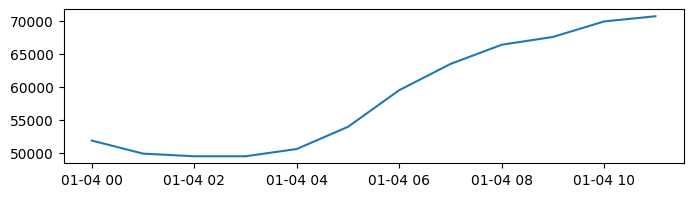

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-04 11:00:00+00:00 to 2024-01-04 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


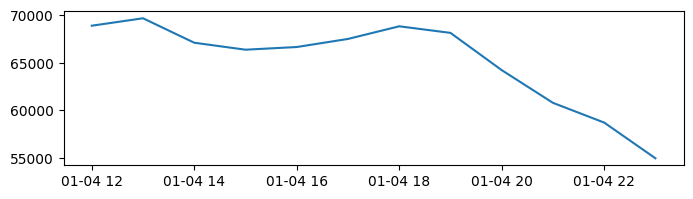

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-04 23:00:00+00:00 to 2024-01-05 10:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


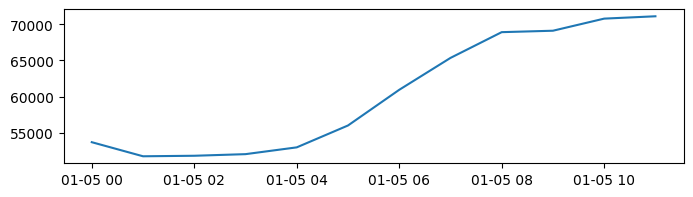

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-05 11:00:00+00:00 to 2024-01-05 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


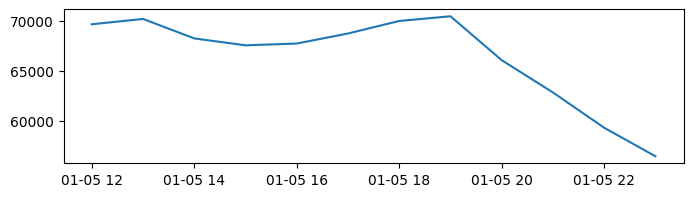

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-05 23:00:00+00:00 to 2024-01-06 10:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


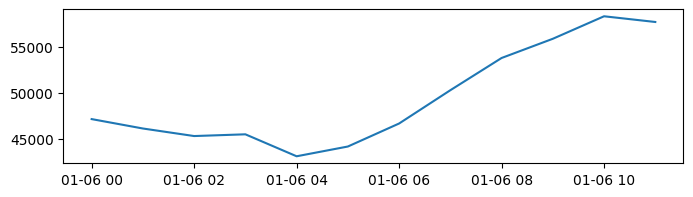

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-06 11:00:00+00:00 to 2024-01-06 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


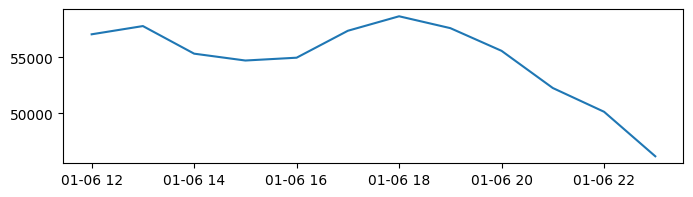

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-06 23:00:00+00:00 to 2024-01-07 10:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


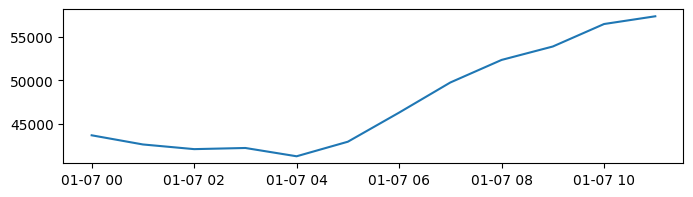

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-07 11:00:00+00:00 to 2024-01-07 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


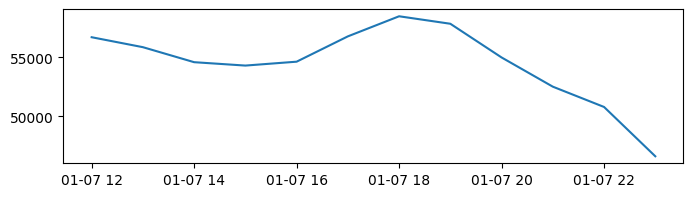

= = = = = = = = = = = = = = = 
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-03 23:00:00+00:00,44891.942285,51002.585218,51875.853231,54168.027723,57455.882983
2024-01-04 00:00:00+00:00,42732.805714,47932.130782,49895.845122,52058.836128,55013.436766
2024-01-04 01:00:00+00:00,42222.313761,46906.774654,49492.349512,51915.008568,54328.704174
2024-01-04 02:00:00+00:00,42437.014067,47294.354864,49492.196732,51972.539383,54264.755518
2024-01-04 03:00:00+00:00,44233.759205,49231.437303,50593.222198,52414.952192,54407.680869
...,...,...,...,...,...
2024-01-07 18:00:00+00:00,50444.002514,55862.725911,57861.048879,59047.555275,62356.145990
2024-01-07 19:00:00+00:00,47945.026794,52677.355755,55002.261355,56739.441885,59493.091104
2024-01-07 20:00:00+00:00,45066.837634,49835.358456,52524.206906,54275.310941,56307.888948
2024-01-07 21:00:00+00:00,43371.204077,48070.856409,50801.867545,52340.945245,55824.532347


In [10]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset to create future features for fcast
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(start, end)

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_iter_all = pd.DataFrame()

for fcast_iter in range(8):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        # print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print('- '*15) 
    print(f"> to be forecasted")
    print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    print('- '*15)    
    print(f'> start prediction ...')

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    plt.figure(figsize=(8,2))
    plt.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)
    plt.show()

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_iter_all = pd.concat((df_fcast_iter_all, df_ens_fcast_out))

print('= '*15)
print('= '*15)
print(f"all iterative fcasts done ...")
display(df_fcast_iter_all)

#### Fix QC & Save to csv

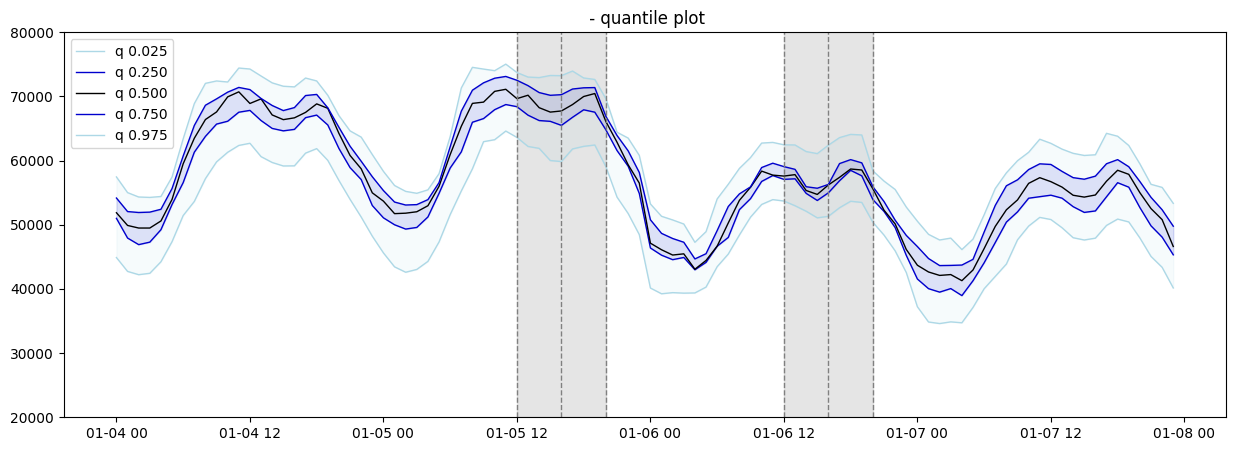

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-03,energy,36 hour,64.603698,68.738141,71.116032,73.117551,75.035538
1,2024-01-03,energy,40 hour,60.011560,66.120070,67.560355,70.178882,73.267289
2,2024-01-03,energy,44 hour,62.431783,67.548345,70.455279,71.383528,72.649778
3,2024-01-03,energy,60 hour,53.919582,57.670664,57.740170,59.596876,62.837272
4,2024-01-03,energy,64 hour,51.081869,53.791031,54.729454,55.695257,61.091071
5,2024-01-03,energy,68 hour,53.482846,57.628138,58.537187,59.651545,63.996559


In [11]:
# - - - - - - - - - - - - - 
# fix quantile crossing
df_iter_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_iter_all)
# current fcast index is based on UTC only, add CET col
df_iter_fcast_all_fixed['timestamp_CET'] = df_iter_fcast_all_fixed.index.tz_convert('CET')
# reorder cols
df_iter_fcast_all_fixed = df_iter_fcast_all_fixed[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_iter_fcast_all_fixed, subm_timestamps)

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_iter_fcast_all_fixed['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_iter_fcast_all_fixed.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

# save entire iterative fcast to csv
df_iter_fcast_all_fixed.to_csv(f"{path}/{fname_time}_power_iterative_fcast.csv", index=False)

# save submission fcast to csv
df_sub.to_csv(f"{path}/{fname_time}_power_fcast_submission.csv", index=False)
display(df_sub)

### Direct h-step Quant Reg Fcast

In [12]:
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

print('- '*15) 
print(f"> to be forecasted")
print(f"{fcast_timestamp_UTC.min()} to {fcast_timestamp_UTC.max()}")

# create df with fcast timestamps 
df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
df_temp['timestamp_CET'] = fcast_timestamp_CET
df_fcast_dummy = data_prepro.create_dummy_df(df_temp, hour_method='seasonal', holiday_method='separate')
# display(df_fcast_dummy)
# display(df_fcast_dummy.tail())

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# fcast

print('- '*15)    
print(f'> start prediction ...')

# save fcast in df with columns = quantiles
df_quant_reg_direct_fcast = pd.DataFrame(index=df_fcast_dummy.index)

# Prediction for Quantile Regression
for name, quant_reg_model in sorted(all_models_quant_reg.items()):
    pred = quant_reg_model.predict(df_fcast_dummy.drop('timestamp_CET', axis=1))
    df_quant_reg_direct_fcast[name] = pred

- - - - - - - - - - - - - - - 
> to be forecasted
2024-01-03 23:00:00+00:00 to 2024-01-07 22:00:00+00:00
- - - - - - - - - - - - - - - 
> start prediction ...


#### Fix QC and Save

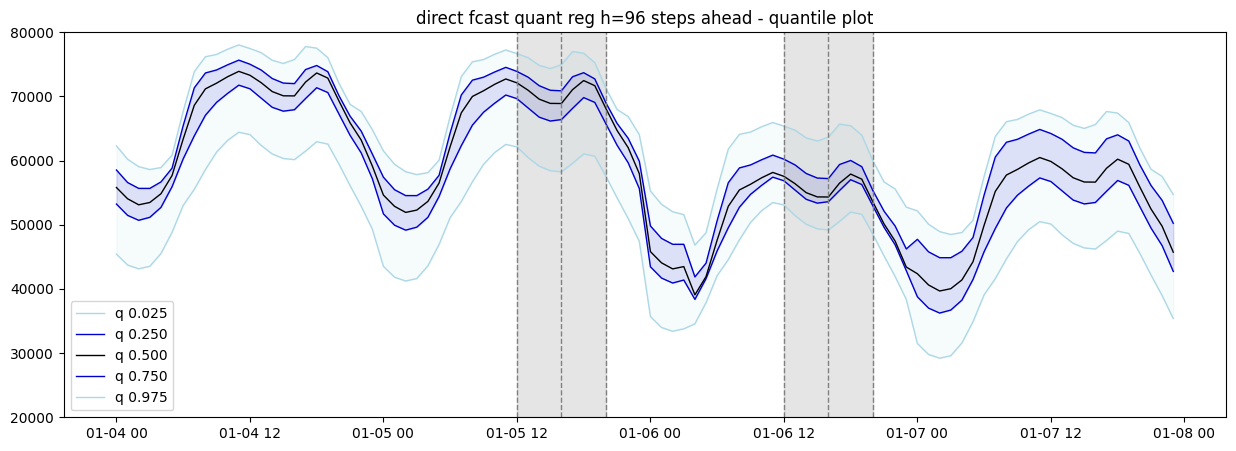

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-03,energy,36 hour,62.517250,70.221762,72.725875,74.536375,77.239167
1,2024-01-03,energy,40 hour,58.425583,66.169988,68.914875,70.962937,74.352083
2,2024-01-03,energy,44 hour,60.675167,69.070725,71.678125,72.734750,75.263694
3,2024-01-03,energy,60 hour,53.462083,57.424300,58.156750,60.858500,65.941222
4,2024-01-03,energy,64 hour,49.370417,53.372525,54.345750,57.285063,63.054139
5,2024-01-03,energy,68 hour,51.620000,56.273262,57.109000,59.056875,63.965750


In [13]:
# - - - - - - - - - - - - - 
# add CET col
df_quant_reg_direct_fcast['timestamp_CET'] = df_quant_reg_direct_fcast.index.tz_convert('CET')
# reorder cols
df_quant_reg_direct_fcast = df_quant_reg_direct_fcast[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]

# - - - - - - - - - - - - - 
# plot + highlight submission horizons
model_train.plot_quantile_fcast(df_quant_reg_direct_fcast, subm_timestamps, title='direct fcast quant reg h=96 steps ahead')

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
mask = df_quant_reg_direct_fcast['timestamp_CET'].isin(subm_timestamps) 
# shift mask by 1
mask = mask.shift(-1).fillna(False)
df_submission = df_quant_reg_direct_fcast.loc[mask,:]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

display(df_sub)

### Naive Benchmark

In [14]:
print(df_energy.info())
df_energy.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78960 entries, 2014-12-31 23:00:00+00:00 to 2024-01-03 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78960 non-null  datetime64[ns, CET]
 1   gesamt         78960 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-03 18:00:00+00:00,2024-01-03 19:00:00+01:00,60750.25
2024-01-03 19:00:00+00:00,2024-01-03 20:00:00+01:00,56969.25
2024-01-03 20:00:00+00:00,2024-01-03 21:00:00+01:00,54318.75
2024-01-03 21:00:00+00:00,2024-01-03 22:00:00+01:00,51718.50
2024-01-03 22:00:00+00:00,2024-01-03 23:00:00+01:00,48127.00


In [15]:
# - - - - - - - - - - - - - 
# create fcast index for next 96 hours
end = df_energy.index.max()
fcast_timestamp_UTC = pd.date_range(start=end, periods=96+1, freq='H')[1:]
fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

fcast_timestamps = fcast_timestamp_CET
# fcast_timestamps = subm_timestamps

# - - - - - - - - - - - - - 
df_energy_benchmark = df_energy.copy()
df_energy_benchmark["month"] = df_energy_benchmark['timestamp_CET'].dt.month
df_energy_benchmark["weekday"] = df_energy_benchmark['timestamp_CET'].dt.weekday # Monday=0, Sunday=6
df_energy_benchmark["weeknum"] = df_energy_benchmark['timestamp_CET'].dt.isocalendar().week

last_t = 100
methods = ['linear', 'median_unbiased', 'normal_unbiased', 'weibull']

number_of_matches_in_past = 0
pred_baseline = np.zeros((len(methods),len(fcast_timestamps),5))

for i,d in enumerate(fcast_timestamps):
        
    weekday = d.weekday()
    hour = d.hour
    weeknum = d.week
    
    # condition that the weekday and hour match AND the weeknum is within +/- 2 weeks of the target
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['weeknum'].between(weeknum-2, weeknum+2)) 
    
    # alternatively:
    # condition that the weekday and hour match AND the month also matches
    # cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark.index.month == d.month)

    # alternatively:
    # condition that the weekday and hour match AND the month is within +/- 1 months of the target
    cond = (df_energy_benchmark.weekday == weekday) & (df_energy_benchmark.index.time == d.time()) & (df_energy_benchmark['month'].between(d.month-1, d.month+1))

    match_df = df_energy_benchmark[cond]
    number_of_matches_in_past += match_df.shape[0] 

    for m_idx, method in enumerate(methods):
        pred_baseline[m_idx, i,:] = np.quantile(match_df.iloc[-last_t:]["gesamt"], q=quantiles, method=method)

number_of_matches_in_past = number_of_matches_in_past / len(fcast_timestamps)
print(f"avg number_of_matches_in_past = {number_of_matches_in_past:.2f}")

dict_benchmark_fcast = {}

for m_idx, method in enumerate(methods):

    print('- '*15)
    print(f"method = {method}")
    print('- '*15)
    
    df_benchmark = pd.DataFrame(index=fcast_timestamps, columns=[f"q {q:.3f}" for q in quantiles])
    df_benchmark.loc[:,:] = pred_baseline[m_idx,:,:]
    # - - - - - - - - - - - - - 
    # make sure all cols are float
    df_benchmark = df_benchmark.astype(float)
    # - - - - - - - - - - - - - 
    # add CET col
    df_benchmark['timestamp_CET'] = df_benchmark.index.tz_convert('CET')
    # reorder cols
    df_benchmark = df_benchmark[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
    # - - - - - - - - - - - - - 
    display(df_benchmark)

    dict_benchmark_fcast[method] = df_benchmark

avg number_of_matches_in_past = 76.25
- - - - - - - - - - - - - - - 
method = linear
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-04 00:00:00+01:00,2024-01-04 00:00:00+01:00,44599.2750,51649.125,52803.00,54918.125,56922.0500
2024-01-04 01:00:00+01:00,2024-01-04 01:00:00+01:00,44315.2000,50646.125,52209.75,53807.375,56288.9125
2024-01-04 02:00:00+01:00,2024-01-04 02:00:00+01:00,44528.3875,50974.250,52219.75,53904.625,56154.1375
2024-01-04 03:00:00+01:00,2024-01-04 03:00:00+01:00,45488.8875,52242.875,53440.00,54950.125,57290.2875
2024-01-04 04:00:00+01:00,2024-01-04 04:00:00+01:00,47978.3750,55121.500,56633.50,58430.625,60373.7250
...,...,...,...,...,...,...
2024-01-07 19:00:00+01:00,2024-01-07 19:00:00+01:00,51441.7000,55230.500,57188.75,58116.750,60555.6250
2024-01-07 20:00:00+01:00,2024-01-07 20:00:00+01:00,49718.0000,53544.750,55632.50,56558.250,58988.9000
2024-01-07 21:00:00+01:00,2024-01-07 21:00:00+01:00,49058.6000,53174.500,55429.50,56779.000,59556.0500
2024-01-07 22:00:00+01:00,2024-01-07 22:00:00+01:00,46159.4250,50212.000,52289.00,54182.750,57409.6000


- - - - - - - - - - - - - - - 
method = median_unbiased
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-04 00:00:00+01:00,2024-01-04 00:00:00+01:00,43746.491667,51641.541667,52803.00,54985.708333,57569.316667
2024-01-04 01:00:00+01:00,2024-01-04 01:00:00+01:00,42562.766667,50632.875000,52209.75,53808.791667,56448.987500
2024-01-04 02:00:00+01:00,2024-01-04 02:00:00+01:00,42643.745833,50971.750000,52219.75,53977.208333,56330.995833
2024-01-04 03:00:00+01:00,2024-01-04 03:00:00+01:00,43715.079167,52224.291667,53440.00,54965.541667,57565.945833
2024-01-04 04:00:00+01:00,2024-01-04 04:00:00+01:00,46076.791667,55062.666667,56633.50,58437.208333,60466.508333
...,...,...,...,...,...,...
2024-01-07 19:00:00+01:00,2024-01-07 19:00:00+01:00,51270.383333,55197.166667,57188.75,58121.000000,61405.083333
2024-01-07 20:00:00+01:00,2024-01-07 20:00:00+01:00,49353.833333,53531.083333,55632.50,56606.000000,59745.100000
2024-01-07 21:00:00+01:00,2024-01-07 21:00:00+01:00,48284.983333,53159.500000,55429.50,56780.000000,60167.533333
2024-01-07 22:00:00+01:00,2024-01-07 22:00:00+01:00,45462.283333,50156.750000,52289.00,54199.000000,57794.983333


- - - - - - - - - - - - - - - 
method = normal_unbiased
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-04 00:00:00+01:00,2024-01-04 00:00:00+01:00,43799.790625,51642.015625,52803.00,54981.484375,57528.862500
2024-01-04 01:00:00+01:00,2024-01-04 01:00:00+01:00,42672.293750,50633.703125,52209.75,53808.703125,56438.982812
2024-01-04 02:00:00+01:00,2024-01-04 02:00:00+01:00,42761.535937,50971.906250,52219.75,53972.671875,56319.942188
2024-01-04 03:00:00+01:00,2024-01-04 03:00:00+01:00,43825.942187,52225.453125,53440.00,54964.578125,57548.717188
2024-01-04 04:00:00+01:00,2024-01-04 04:00:00+01:00,46195.640625,55066.343750,56633.50,58436.796875,60460.709375
...,...,...,...,...,...,...
2024-01-07 19:00:00+01:00,2024-01-07 19:00:00+01:00,51281.090625,55199.250000,57188.75,58120.734375,61351.992188
2024-01-07 20:00:00+01:00,2024-01-07 20:00:00+01:00,49376.593750,53531.937500,55632.50,56603.015625,59697.837500
2024-01-07 21:00:00+01:00,2024-01-07 21:00:00+01:00,48333.334375,53160.437500,55429.50,56779.937500,60129.315625
2024-01-07 22:00:00+01:00,2024-01-07 22:00:00+01:00,45505.854688,50160.203125,52289.00,54197.984375,57770.896875


- - - - - - - - - - - - - - - 
method = weibull
- - - - - - - - - - - - - - - 


,timestamp_CET,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-04 00:00:00+01:00,2024-01-04 00:00:00+01:00,43361.5500,51637.750,52803.00,55019.500,57940.5500
2024-01-04 01:00:00+01:00,2024-01-04 01:00:00+01:00,41959.4500,50626.250,52209.75,53809.500,56647.0250
2024-01-04 02:00:00+01:00,2024-01-04 02:00:00+01:00,41860.8750,50970.500,52219.75,54013.500,56568.8500
2024-01-04 03:00:00+01:00,2024-01-04 03:00:00+01:00,42791.1000,52215.000,53440.00,54973.250,57810.6750
2024-01-04 04:00:00+01:00,2024-01-04 04:00:00+01:00,44810.8750,55033.250,56633.50,58440.500,60544.0750
...,...,...,...,...,...,...
2024-01-07 19:00:00+01:00,2024-01-07 19:00:00+01:00,50882.2125,55180.500,57188.75,58123.125,61771.9875
2024-01-07 20:00:00+01:00,2024-01-07 20:00:00+01:00,48902.2625,53524.250,55632.50,56629.875,60090.5000
2024-01-07 21:00:00+01:00,2024-01-07 21:00:00+01:00,47678.5375,53152.000,55429.50,56780.500,60427.5375
2024-01-07 22:00:00+01:00,2024-01-07 22:00:00+01:00,44868.3625,50129.125,52289.00,54207.125,57994.3875


#### Plot Naive Benchmark

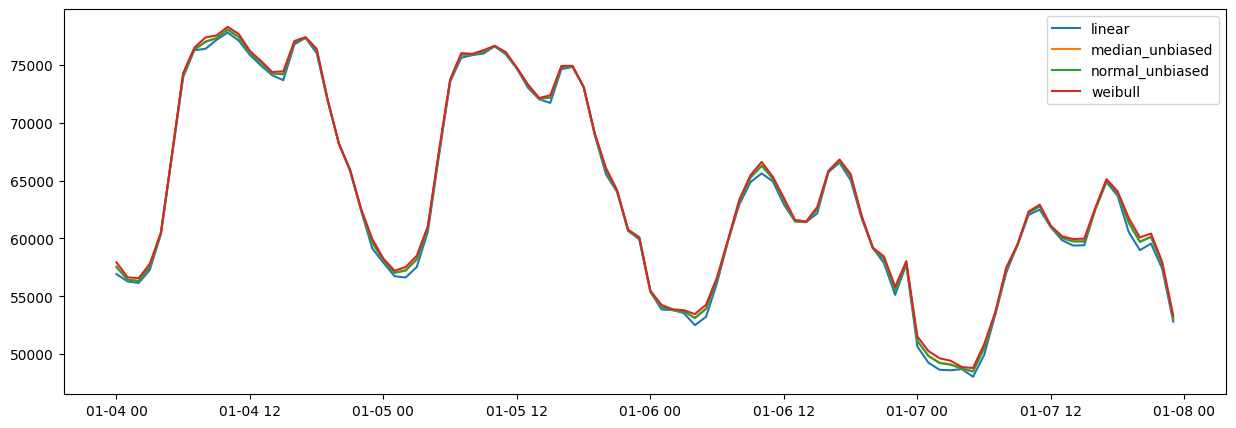

In [16]:
# compare the q 0.975 quantile of all benchmarks
plt.figure(figsize=(15,5))
for method in methods:
    plt.plot(dict_benchmark_fcast[method]['timestamp_CET'], dict_benchmark_fcast[method]['q 0.975'], label=method)
plt.legend()
plt.show()

### Get Actual Data

In [17]:
from importlib import reload
reload(data_prepro)
reload(model_train)

<module 'model_train' from 'C:\\2023_11-PTSFC\\model_train.py'>

In [18]:
""" 
now since we ran the model in retrospect on a past week 
we can compare the fcast with the actual values and compute quantile scores etc

"""

# = = = = = = = = = = = = = 
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = = 
# get data
df_energy_new = data_prepro.get_energy_data_today(to_date=t_wednesday_next.strftime('%Y%m%d'))
df_energy_new.info()
df_energy_new.tail(5)

next thu = 2024-01-10 00:00:00
> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


> 0 NA in df
> last valid index = 2024-01-10 22:45:00+00:00
> done and saved to 2015-01-01_2024-01-10_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79128 entries, 2014-12-31 23:00:00+00:00 to 2024-01-10 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79128 non-null  datetime64[ns, CET]
 1   gesamt         79128 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-10 18:00:00+00:00,2024-01-10 19:00:00+01:00,68668.25
2024-01-10 19:00:00+00:00,2024-01-10 20:00:00+01:00,65446.75
2024-01-10 20:00:00+00:00,2024-01-10 21:00:00+01:00,62176.50
2024-01-10 21:00:00+00:00,2024-01-10 22:00:00+01:00,59633.00
2024-01-10 22:00:00+00:00,2024-01-10 23:00:00+01:00,56738.25


In [19]:
def eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[20_000, 80_000]):

    """ 
    imported data up to (and including) sunday of the fcast week
    first subset the required data from df_energy_new ...ie t_wednesday to t_sunday
    then plot the iterative fcast from thursday to sunday
    against the actual values in the same plot for comparison

    """
    # plot all actual values inbetween fcast timeframe
    mask = (df_energy_new['timestamp_CET'] >= df_fcast['timestamp_CET'].min()) & (df_energy_new['timestamp_CET'] <= df_fcast['timestamp_CET'].max())
    actual_df = df_energy_new.loc[mask]

    # plot actual values only for the fcast timestamps
    # actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # = = = = = = = = = = = = = 
    # plot

    plt.figure(figsize=(15, 5))
    plt.title(f'quantile fcast evaluation')

    for quantile in df_fcast.columns:

        if 'timestamp' in quantile:
            continue

        y_pred = df_fcast[quantile]
        quantile_float = float(quantile[2:])

        # Save predicted values based on quantile
        if '0.025' in quantile:
            y_pred_025 = y_pred
            col = 'lightblue'
        elif '0.25' in quantile:
            y_pred_25 = y_pred
            col = 'mediumblue'
        elif '0.5' in quantile:
            y_pred_50 = y_pred
            col = 'black'
        elif '0.75' in quantile:
            y_pred_75 = y_pred
            col = 'mediumblue'
        elif '0.975' in quantile:
            y_pred_975 = y_pred
            col = 'lightblue'
        
        # Plot the prediction line
        plt.plot(df_fcast['timestamp_CET'], y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

    plt.fill_between(df_fcast['timestamp_CET'], y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
    plt.fill_between(df_fcast['timestamp_CET'], y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)

    # highlight submission timeframes
    plt.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
    plt.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

    # for timestamp in submission idx, make vertical line
    for timestamp in subm_timestamps:
        plt.axvline(timestamp, color='grey', linestyle='--', lw=1)

    # plot actual values
    plt.plot(actual_df['timestamp_CET'], actual_df['gesamt'], lw=1, label='actual', color='red')

    plt.ylim(ylims)
    plt.legend()
    plt.show()

    """ 
    to calculate the error, we can only subset the actual values for the fcast timestamps
    because otherwise the actual_df will have more values than the fcast_df
    
    now that everything lines up ... we can compute the quantile scores 
    and other error metrics such as MAE, MAPE, MSE, etc
    do it for the entire iterative fcast and also for the 6 submission fcast timestamps

    """

    actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # for entire iterative fcast
    # ==========================
    print('- '*15)
    print(f"entire iterative fcast")
    print('- '*15)

    mae = mean_absolute_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAE = {mae}")
    mse = mean_squared_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MSE = {mse}")
    mape = mean_absolute_percentage_error(actual_df['gesamt'], df_fcast['q 0.500'])
    print(f"MAPE = {mape}")

    quantile_scores = []
    for q in quantiles:
        quantile_scores.append(mean_pinball_loss(actual_df['gesamt'], df_fcast[f'q {q:.3f}']))
    print(quantile_scores)

    # for submission fcast timestamps
    # ===============================
    print('- '*15)
    print(f"submission fcast timestamps")
    print('- '*15)

    mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'].isin(subm_timestamps), 'gesamt'].values, 
                              df_fcast.loc[df_fcast['timestamp_CET'].isin(subm_timestamps), 'q 0.500'].values)
    print(f"MAE q 0.5 = {mae}")

    df_error_metrics = pd.DataFrame(index=subm_timestamps)
    for timestamp in subm_timestamps:
        mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, 'q 0.500'].values)
        df_error_metrics.loc[timestamp, 'abs error q 0.5'] = mae

        for q in quantiles:
            quantile_score = mean_pinball_loss(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                            df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, f'q {q:.3f}'].values,
                                            alpha=q)
            # save in df
            df_error_metrics.loc[timestamp, f'q-score {q:.3f}'] = quantile_score

    # add last row to df_error_metrics which is the avg of the cols
    df_error_metrics.loc['avg', :] = df_error_metrics.mean(axis=0)
    
    display(df_error_metrics)

### Evaluation

#### Evaluate only Submission File

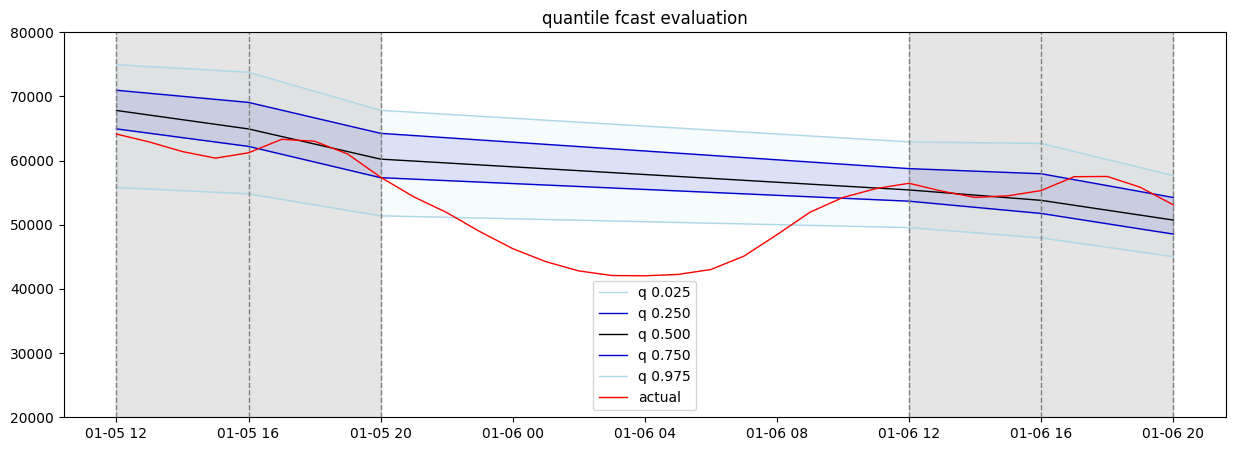

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 2524.9296874999964
MSE = 7385758.579386368
MAPE = 0.04296348546321253
[3590.9460937499994, 1065.1822916666667, 1262.4648437499982, 2298.2682291666647, 4348.561718750004]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 2524.9296874999964


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,3675.093750,208.267266,605.859375,1837.546875,1706.929687,270.423750
2024-01-05 16:00:00+01:00,3718.218750,159.869922,749.718750,1859.109375,1963.664062,314.006250
2024-01-05 20:00:00+01:00,2822.843750,150.277266,16.570312,1411.421875,1711.101562,260.737578
2024-01-06 12:00:00+01:00,1039.953125,172.678984,698.156250,519.976562,570.703125,161.352109
2024-01-06 16:00:00+01:00,1526.265625,184.487891,891.851562,763.132812,655.265625,183.591484
2024-01-06 20:00:00+01:00,2367.203125,201.702500,1137.109375,1183.601562,287.140625,114.457344
avg,2524.929687,179.547305,683.210938,1262.464844,1149.134115,217.428086


In [25]:
# read in csv file

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

# get csv filename from path that includes Thormund
fnames = [f for f in os.listdir(path) if 'Tormund' in f]
if len(fnames) > 0:
    fname = fnames[0]
else:
    print("no file found")

df_fcast = pd.read_csv(f"{path}/{fname}")
df_fcast = df_fcast[df_fcast.target == 'energy']
df_fcast['timestamp_CET'] = subm_timestamps
# make index = timestamp_CET turned to UTC
df_fcast.index = pd.to_datetime(df_fcast['timestamp_CET']).dt.tz_convert('UTC').rename('timestamp_UTC')
df_fcast = df_fcast[['timestamp_CET', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']]
df_fcast.columns = ['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']
df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] = df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] * 1000
# display(df_fcast)

eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles)

#### Evaluate Entire Fcast

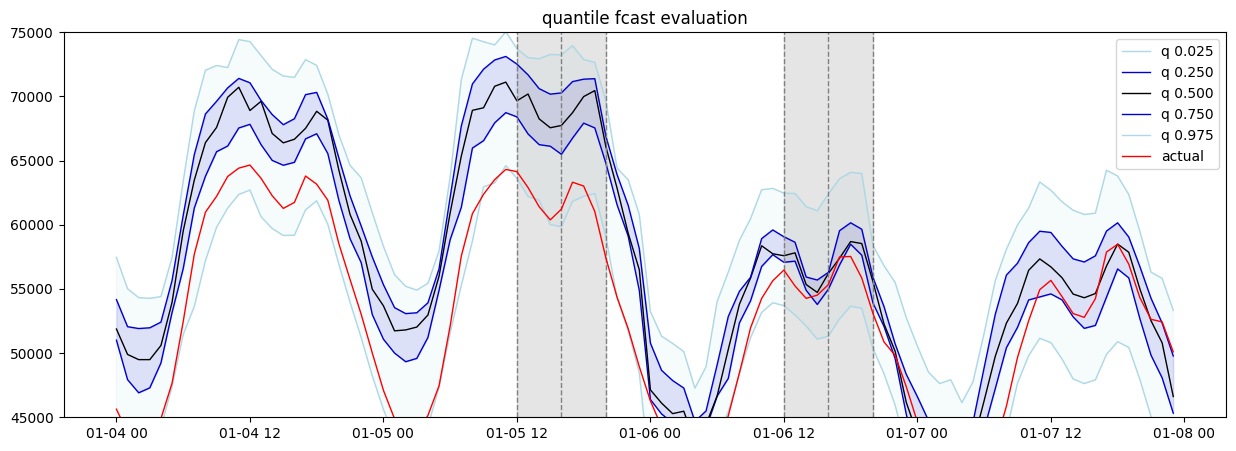

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 4322.728645255105
MSE = 25985352.31484117
MAPE = 0.08190701255142642
[1371.822191026399, 1586.3537416851243, 2161.3643226275526, 2973.0023837290196, 4476.874471813319]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 4199.208284243789


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,5519.493563,13.103263,3199.800934,2759.746781,2094.717041,239.720060
2024-01-05 16:00:00+01:00,6520.349617,34.170784,3204.946611,3260.174808,2264.451975,300.530939
2024-01-05 20:00:00+01:00,8670.326820,1596.308896,5532.022462,4335.163410,2368.959756,305.816910
2024-01-06 12:00:00+01:00,1118.508184,69.178122,454.633132,559.254092,648.979959,149.862633
2024-01-06 16:00:00+01:00,875.708098,100.391824,88.106712,437.854049,239.632033,176.732968
2024-01-06 20:00:00+01:00,2490.863424,68.163091,608.888631,1245.431712,704.072217,132.344930
avg,4199.208284,313.552663,2181.399747,2099.604142,1386.802164,217.501407


In [22]:
eval_fcast(df_iter_fcast_all_fixed, df_energy_new, subm_timestamps, quantiles, ylims=[45_000, 75_000])

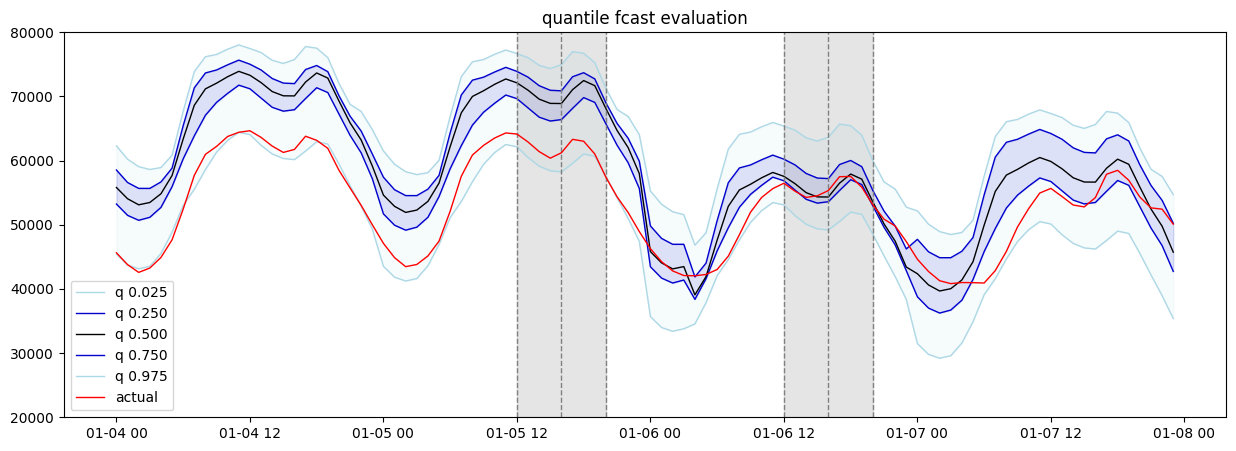

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6200.341145833333
MSE = 53168234.73763021
MAPE = 0.11693076879102353
[1989.3741319444443, 2317.5235677083333, 3100.1705729166665, 4228.143229166667, 6041.533854166667]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 4816.229166666667


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,7977.125000,49.804167,4137.768750,3988.562500,2440.750000,313.404861
2024-01-05 16:00:00+01:00,7679.875000,74.214583,3883.162500,3839.937500,2415.015625,343.563194
2024-01-05 20:00:00+01:00,10711.375000,148.687500,6239.681250,5355.687500,2898.718750,346.571528
2024-01-06 12:00:00+01:00,1077.250000,84.452083,291.609375,538.625000,938.593750,222.687500
2024-01-06 16:00:00+01:00,1005.500000,153.500000,434.040625,502.750000,466.484375,208.208333
2024-01-06 20:00:00+01:00,446.250000,114.966667,43.471875,223.125000,555.250000,171.722917
avg,4816.229167,104.270833,2504.955729,2408.114583,1619.135417,267.693056


In [23]:
eval_fcast(df_quant_reg_direct_fcast, df_energy_new, subm_timestamps, quantiles)

#### Evaluation of Benchmark

method = linear


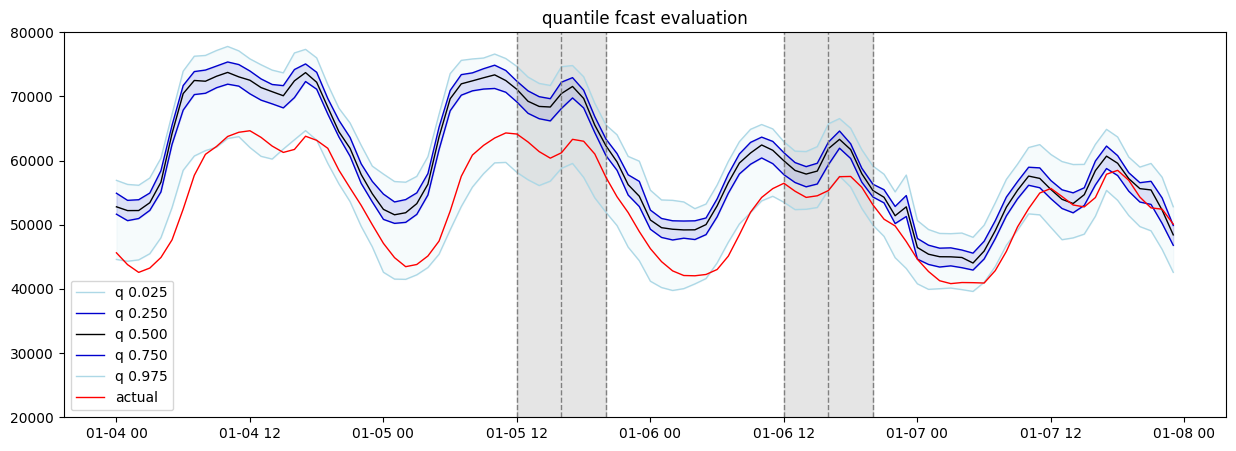

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[1448.1023111979166, 2633.9521484375, 3344.169921875, 4049.1819661458335, 5288.098763020832]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,149.451562,3746.25000,3481.06250,2056.000000,263.432031
2024-01-05 16:00:00+01:00,9232.1250,60.762500,5182.50000,4616.06250,2750.015625,335.393750
2024-01-05 20:00:00+01:00,4915.6250,136.388281,2534.81250,2457.81250,1489.906250,203.749219
2024-01-06 12:00:00+01:00,3498.7500,74.089375,1002.37500,1749.37500,1190.312500,161.666250
2024-01-06 16:00:00+01:00,6524.7500,56.233125,3019.50000,3262.37500,1886.375000,259.821250
2024-01-06 20:00:00+01:00,2238.2500,78.848125,924.37500,1119.12500,804.875000,151.281875
avg,5561.9375,92.628828,2734.96875,2780.96875,1696.247396,229.224063


method = median_unbiased


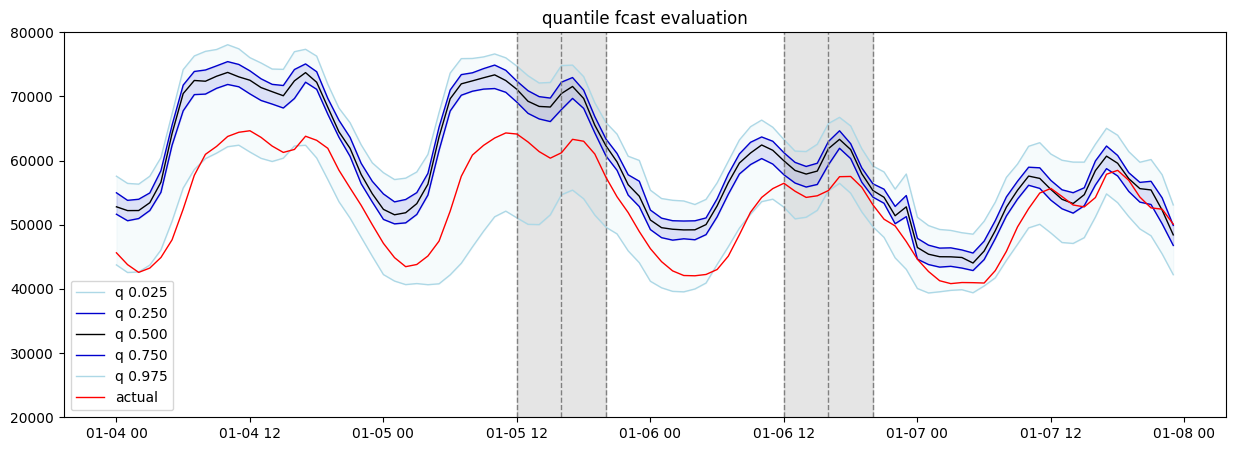

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[2156.9094292534724, 2616.459526909722, 3344.169921875, 4059.8364800347226, 5419.785091145834]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,326.634479,3719.5000,3481.06250,2059.500000,264.417656
2024-01-05 16:00:00+01:00,9232.1250,163.615833,5055.0000,4616.06250,2750.453125,339.858750
2024-01-05 20:00:00+01:00,4915.6250,194.595573,2499.0625,2457.81250,1491.614583,213.055260
2024-01-06 12:00:00+01:00,3498.7500,93.220000,993.2500,1749.37500,1191.312500,170.437917
2024-01-06 16:00:00+01:00,6524.7500,0.786667,3004.6250,3262.37500,1909.791667,261.064167
2024-01-06 20:00:00+01:00,2238.2500,85.367500,907.9375,1119.12500,820.958333,151.404583
avg,5561.9375,144.036675,2696.5625,2780.96875,1703.938368,233.373056


method = normal_unbiased


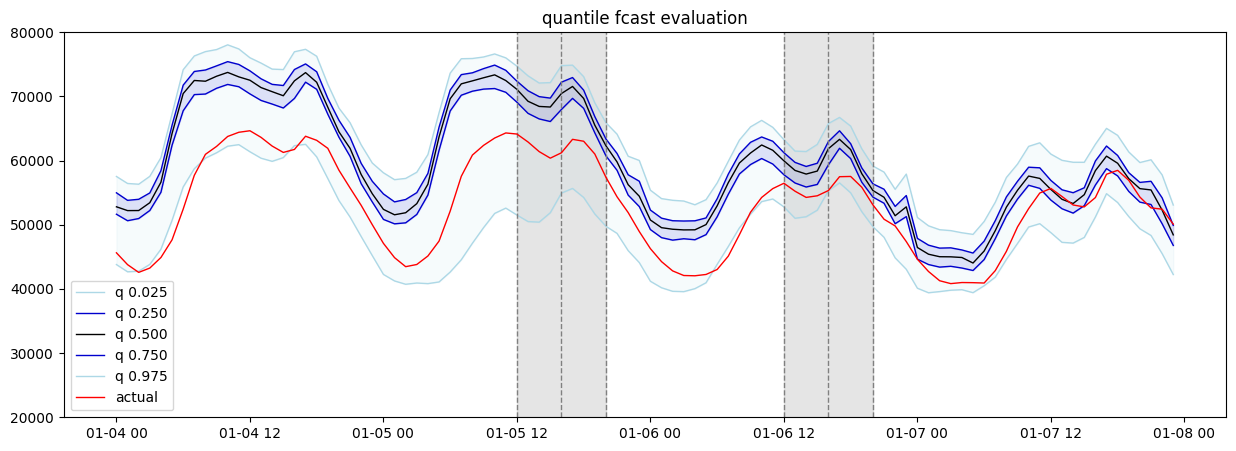

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[2109.7879964192707, 2617.5528157552085, 3344.169921875, 4059.1705729166665, 5411.554695638021]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,315.560547,3721.171875,3481.06250,2059.281250,264.356055
2024-01-05 16:00:00+01:00,9232.1250,157.187500,5062.968750,4616.06250,2750.425781,339.579688
2024-01-05 20:00:00+01:00,4915.6250,190.957617,2501.296875,2457.81250,1491.507812,212.473633
2024-01-06 12:00:00+01:00,3498.7500,92.024336,993.820312,1749.37500,1191.250000,169.889688
2024-01-06 16:00:00+01:00,6524.7500,0.647383,3005.554688,3262.37500,1908.328125,260.986484
2024-01-06 20:00:00+01:00,2238.2500,84.960039,908.964844,1119.12500,819.953125,151.396914
avg,5561.9375,140.222904,2698.962891,2780.96875,1703.457682,233.113743


method = weibull


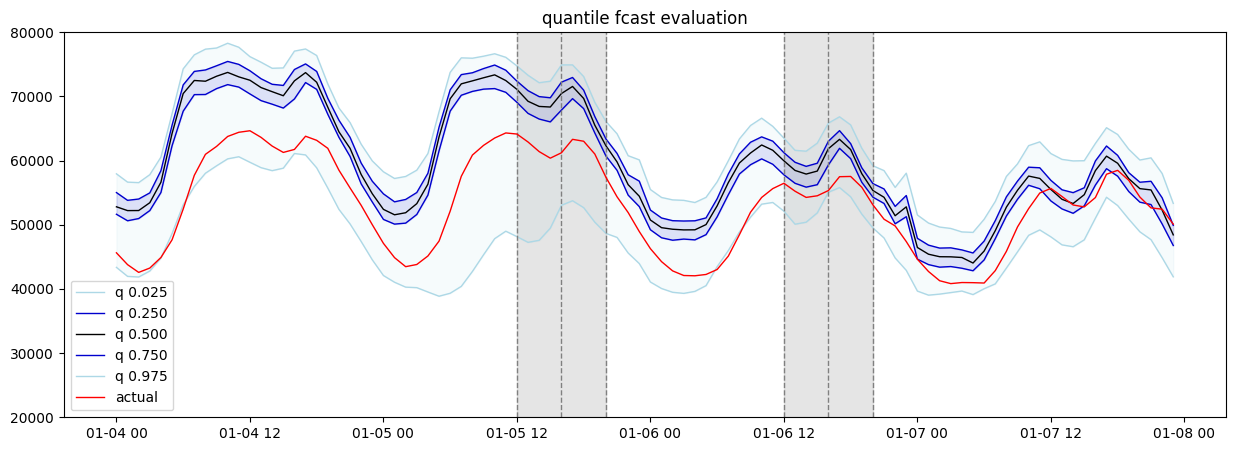

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
MAE = 6688.33984375
MSE = 60096901.95296224
MAPE = 0.12808195265973898
[2577.60048828125, 2607.7132161458335, 3344.169921875, 4065.1637369791665, 5498.529882812498]
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
MAE q 0.5 = 5561.9375


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-05 12:00:00+01:00,6962.1250,399.647031,3706.125000,3481.06250,2061.250000,265.351563
2024-01-05 16:00:00+01:00,9232.1250,204.615156,4991.250000,4616.06250,2750.671875,342.358906
2024-01-05 20:00:00+01:00,4915.6250,218.650781,2481.187500,2457.81250,1492.468750,217.300000
2024-01-06 12:00:00+01:00,3498.7500,108.810000,988.687500,1749.37500,1191.812500,175.774063
2024-01-06 16:00:00+01:00,6524.7500,6.550625,2997.187500,3262.37500,1921.500000,262.672500
2024-01-06 20:00:00+01:00,2238.2500,90.075937,899.718750,1119.12500,829.000000,152.440313
avg,5561.9375,171.391589,2677.359375,2780.96875,1707.783854,235.982891


In [26]:
# iterate over dict dict_benchmark_fcast
for method, df_benchmark in dict_benchmark_fcast.items():
    print(f"method = {method}")
    eval_fcast(df_benchmark, df_energy_new, subm_timestamps, quantiles)